In [1]:
import numpy as np

from math import ceil

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [15]:
h = 0.1
tao = 0.1

u_t0 = lambda x,y:1+x*y
u_x0 = lambda y,t: 1 + (np.exp(t) - np.exp(-np.pi**2*t))*np.sin(np.pi*y/2)/(1+np.pi**2)
u_y0 = lambda x,t: 1
u_x1 = lambda y,t: 1+y
u_y1 = lambda x,t:1+x+(np.exp(t) - np.exp(-np.pi**2*t))*np.cos(np.pi*x/2)/(1+np.pi**2)

f = lambda x,y,t: np.exp(t)*np.cos(np.pi*x/2)/(1+np.pi**2)*np.sin(np.pi*y/2)/(1+np.pi**2)

In [16]:
# матрица системы

def get_matr(tao, h, n):
    matr = np.zeros((n,n))
    matr[0,0]=1+2*tao/h**2
    matr[0,1]=-tao/h**2

    for i in range(1,n-1):
        matr[i,i] = 1+2*tao/h**2
        matr[i,i-1] = -tao/h**2
        matr[i,i+1] = -tao/h**2
  
    matr[-1,-2] = -tao/h**2
    matr[-1,-1] = 1+2*tao/h**2

    return matr

In [17]:
# метод прогонки

def shuttle_solve(A_,b):
  # A = csr_matrix.copy(A_)
    A = np.copy(A_)
  # print(A.toarray())
    for i in range(1,b.shape[0]):
        A[i,i] -= A[i,i-1]*A[i-1,i]/A[i-1,i-1]
        b[i] -=  A[i,i-1]*b[i-1]/A[i-1,i-1]

    x = np.zeros_like(b)

    x[-1] = b[-1]/A[-1, -1]

    for i in range(x.shape[0]-2,-1,-1):
        x[i] = (b[i] - A[i,i+1]*x[i+1])/A[i,i]

    return x

In [18]:
def get_partial_diff(x, h):
    return np.array([(x[0,i]+x[2,i]-2*x[1,i])/h**2 for i in range(1,int(1/h))])

In [19]:
def get_step(last_lr, h, tao, n,u_x0 ,u_y0, u_x1, u_y1,f,matr, t, fst):
    
    sol_grid = np.zeros(last_lr.shape)
    x = np.arange(0,1+h,h)
    sol_grid[0,:] =  u_x0(x, t)
    sol_grid[-1,:] = u_x1(x, t)
    sol_grid[:,0] =  u_y0(x, t)
    sol_grid[:,-1] = u_y1(x, t)
    
    if not fst:
        sol_grid = sol_grid.T
        last_lr = np.copy(last_lr.T)
        f = f.T
    
    for i in range(1,int(1/h)):
        
        b = np.copy(last_lr[i,1:-1])+f[i,1:-1]*tao + get_partial_diff(last_lr[i-1:i+2], h)*tao
        
        if fst:
            b[0]+=u_y0(i*h, t)*tao/h**2
            b[-1]+=u_y1(i*h, t)*tao/h**2
        else:
            b[0]+=u_x0(i*h, t)*tao/h**2
            b[-1]+=u_x1(i*h, t)*tao/h**2

        sol_grid[i,1:-1] = shuttle_solve(matr, b)
    
    return sol_grid if fst else sol_grid.T  
    

In [28]:
def peaceman_rachford_solve(h,tao,f, u_t0 ,u_x0 ,u_y0, u_x1, u_y1, T=1):
    x = np.arange(0,1+h,h)
    xx, xx_ = np.meshgrid(x,x)
    layers = [u_t0(xx, xx_)]
    
    matr = get_matr(tao/2,h, x.shape[0]-2)
    print(matr)
    for n in range(1,int(1/tao)):
        
        step1 = get_step(layers[n-1], h, tao/2, n,u_x0 ,u_y0, u_x1, u_y1,
                         f(xx,xx,(n-1/2)*tao),matr = matr, t = (n-1/2)*tao, fst = True)
        step2 = get_step(step1, h, tao/2, n,u_x0 ,u_y0, u_x1, u_y1,
                         f(xx,xx,n*tao),matr = matr, t = n*tao, fst = False)
        
        layers.append(step2)
    
    return np.stack(layers)

In [29]:
Xh = peaceman_rachford_solve(h,tao,f, u_t0 ,u_x0 ,u_y0, u_x1, u_y1)

[[11. -5.  0.  0.  0.  0.  0.  0.  0.]
 [-5. 11. -5.  0.  0.  0.  0.  0.  0.]
 [ 0. -5. 11. -5.  0.  0.  0.  0.  0.]
 [ 0.  0. -5. 11. -5.  0.  0.  0.  0.]
 [ 0.  0.  0. -5. 11. -5.  0.  0.  0.]
 [ 0.  0.  0.  0. -5. 11. -5.  0.  0.]
 [ 0.  0.  0.  0.  0. -5. 11. -5.  0.]
 [ 0.  0.  0.  0.  0.  0. -5. 11. -5.]
 [ 0.  0.  0.  0.  0.  0.  0. -5. 11.]]


In [22]:
Xh[1][:,-1]

array([1.06738636, 1.16655672, 1.26408824, 1.36004169, 1.45451671,
       1.54764935, 1.63960871, 1.73059277, 1.82082353, 1.91054155,
       2.        ])

In [23]:
u_true = lambda t,x,y: 1+ x*y + (np.exp(t) - np.exp(-np.pi**2*t))*np.sin(np.pi*y/2)*np.cos(np.pi*x/2)/(1+np.pi**2)

def function_on_grid(h, tao, func, T=1):

  # функция возвращает значения на сетке

  x = np.arange(0,1+1e-10,h)
  t = np.arange(0,T+1e-10, tao)

  T_, X, Y = np.meshgrid(t, x, x)

  return func(T_, X, Y)

In [24]:
true_grid = function_on_grid(h,tao,u_true)

In [25]:
def visualize(h, z,zh):

  # функция для визуализации реального и численного решений

  x = np.arange(0,1+1e-10,h)

  X_, X = np.meshgrid(x, x)

  fig = plt.figure(figsize=(15,7))

  ax = fig.add_subplot(1, 2, 1, projection='3d')


  surf = ax.plot_surface(X_,X, z.T, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
  ax.text2D(0.05, 0.95, "True solution", transform=ax.transAxes)
  
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  surf1 = ax.plot_surface(X_,X, zh.T, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
  ax.text2D(0.05, 0.95, "Numerical solution", transform=ax.transAxes)

  plt.show()

In [26]:
k = 99
visualize(h,true_grid[:,k].T, Xh[k].T)

IndexError: index 99 is out of bounds for axis 1 with size 11

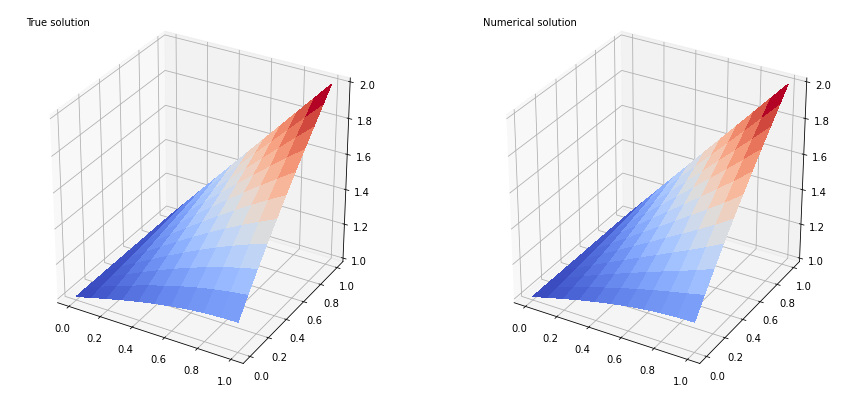

In [27]:
k = 5
visualize(h,true_grid[:,k].T, Xh[k].T)